# Task 3: Gambling task

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from scipy.stats import linregress, ttest_ind
from os.path import join
from matplotlib.colors import LinearSegmentedColormap
from seaborn.utils import relative_luminance
from seaborn.palettes import color_palette
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
DATA_FOLDER = 'data'
RESULTS_FOLDER = 'results/GamblingTask/'
GAMBLING_TASK = 'GamblingTask'
QUESTIONNAIRE = 'QuestionnaireData.csv'

num_participants = 164
remove_ids = [97, 105, 117, 36, 44, 90, 93, 95, 106, 134, 136, 155]

subject_ids = [i for i in range(1, num_participants + 1) if i not in remove_ids]

In [3]:
questionnaire_data = pd.read_csv(f'{DATA_FOLDER}/{QUESTIONNAIRE}')
questionnaire_data = questionnaire_data[~questionnaire_data['subj'].isin(remove_ids)]
questionnaire_data.reset_index(drop=True, inplace=True)
questionnaire_data.shape

(152, 17)

## Gambling task variables
- ppnr = participant number
- order = order in which the decks were presented, between 0 and 23 (24 possibilities)
- trialnr = trial number
- amount_won = amount of money won in current trial
- W_value_win = money that can be won in fixed deck in current trial
- X_value_win = money than can be won in SD = 10 deck in current trial
- Y_value_win = money that can be won in SD = 30 deck in current trial
- Z_value_win = money that can be won in SD = 70 deck in current trial
- r = response (1 = most left deck chosen, 2 = middle left chosen, 3 = middle right chosen, 4 = most right deck chosen)
- real_r = response (0 = fixed deck chosen, 1 = SD10 deck chosen, 2 = SD30 deck chosen, 3 = SD70 deck chosen)
- rt = reaction time in miliseconds
- money = total amount of money gathered in previous trials

In [4]:
file_path = f'{DATA_FOLDER}/{GAMBLING_TASK}/gambling_ppn01.rtd'
df = pd.read_csv(file_path, delimiter='\t')
df.shape

(200, 12)

In [6]:
# Read data for each participant and combine into a single dataframe
gambling_task_data = pd.DataFrame()

for subject_id in subject_ids:
    file_name = f"gambling_ppn{'0' + str(subject_id) if subject_id < 10 else str(subject_id)}.rtd"
    file_path = join(DATA_FOLDER, GAMBLING_TASK, file_name)
    temp_df = pd.read_csv(file_path, sep="\t", header=0)
    gambling_task_data = pd.concat([gambling_task_data, temp_df], ignore_index=True)
gambling_task_data.shape

(30400, 12)

In [7]:
# Check the columns in the dataframe
gambling_task_data.columns

Index(['ppnr', 'order', 'trialnr', 'amount_won', 'W_value_win', 'X_value_win',
       'Y_value_win', 'Z_value_win', 'r', 'real_r', 'rt', 'money'],
      dtype='object')

In [8]:
# Make a dataframe which counts the occurence of each choice for each participant
choices = pd.DataFrame(np.zeros((len(subject_ids), 5)), columns=["ppnr", "fixed", "SD10", "SD30", "SD70"])
choices["ppnr"] = subject_ids

# Loop over each subject
for k, subject_id in enumerate(subject_ids):
    # Count occurrences of each response type for the current subject
    choices.loc[k, "SD70"] = len(gambling_task_data[(gambling_task_data["real_r"] == 3) & (gambling_task_data["ppnr"] == subject_id)])
    choices.loc[k, "SD30"] = len(gambling_task_data[(gambling_task_data["real_r"] == 2) & (gambling_task_data["ppnr"] == subject_id)])
    choices.loc[k, "SD10"] = len(gambling_task_data[(gambling_task_data["real_r"] == 1) & (gambling_task_data["ppnr"] == subject_id)])
    choices.loc[k, "fixed"] = len(gambling_task_data[(gambling_task_data["real_r"] == 0) & (gambling_task_data["ppnr"] == subject_id)])

# Convert float columns to integers
choices = choices.astype({"fixed": int, "SD10": int, "SD30": int, "SD70": int})


In [9]:
# Filter out the participants who have chosen one or more decks less than 5 times
choices = choices[(choices["fixed"] >= 5) & (choices["SD10"] >= 5) & (choices["SD30"] >= 5) & (choices["SD70"] >= 5)]
excluded_participants = [i for i in subject_ids if i not in choices["ppnr"].values]
excluded_participants

[]

In [10]:
# Create a dataframe to store reaction time mean and standard deviation
reaction_time_mean = pd.DataFrame(columns=["ppnr", "mean", "sd"])
reaction_time_mean["ppnr"] = subject_ids

# Loop over each subject
for subject_id in subject_ids:
    # Calculate mean and standard deviation of reaction time for the current subject
    subject_data = gambling_task_data[gambling_task_data["ppnr"] == subject_id]
    mean_rt = subject_data["rt"].mean()
    sd_rt = subject_data["rt"].std()
    
    # Add mean and standard deviation to the dataframe
    reaction_time_mean.loc[reaction_time_mean["ppnr"] == subject_id, "mean"] = mean_rt
    reaction_time_mean.loc[reaction_time_mean["ppnr"] == subject_id, "sd"] = sd_rt

In [11]:
# Identify and mark outliers
for i, row in gambling_task_data.iterrows():
    participant_id = row["ppnr"]
    mean_rt = reaction_time_mean.loc[reaction_time_mean["ppnr"] == participant_id, "mean"].iloc[0]
    sd_rt = reaction_time_mean.loc[reaction_time_mean["ppnr"] == participant_id, "sd"].iloc[0]
    if row["rt"] - mean_rt > 3 * sd_rt:
        gambling_task_data.at[i, "rt"] = np.nan
        gambling_task_data.at[i, "real_r"] = np.nan

# Remove rows with NA values
gambling_task_data.dropna(inplace=True)

## Deck choice preference

In [12]:
# Get the preference dataframe
preference = pd.DataFrame(np.zeros((len(subject_ids), 5)), columns=["ppnr", "fixed", "SD10", "SD30", "SD70"])
preference["ppnr"] = subject_ids

# Loop over each subject
for k, subject_id in enumerate(subject_ids):
    # Subset data for the current subject
    subject_data = gambling_task_data[gambling_task_data["ppnr"] == subject_id]
    
    # Count occurrences of each deck choice
    num_fixed = len(subject_data[subject_data["real_r"] == 0])
    num_sd10 = len(subject_data[subject_data["real_r"] == 1])
    num_sd30 = len(subject_data[subject_data["real_r"] == 2])
    num_sd70 = len(subject_data[subject_data["real_r"] == 3])
    
    # Calculate proportions and store in the dataframe
    total_choices = num_fixed + num_sd10 + num_sd30 + num_sd70
    preference.loc[k, "fixed"] = num_fixed / total_choices
    preference.loc[k, "SD10"] = num_sd10 / total_choices
    preference.loc[k, "SD30"] = num_sd30 / total_choices
    preference.loc[k, "SD70"] = num_sd70 / total_choices

# Convert float columns to percentages
preference[["fixed", "SD10", "SD30", "SD70"]] *= 100

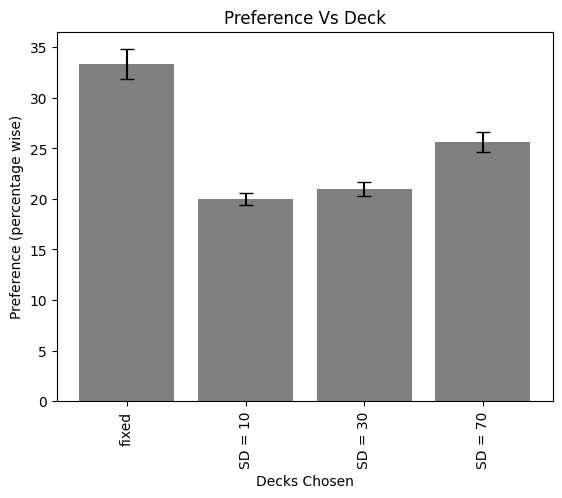

In [14]:
# Plot a barplot of preference against standard error of mean
preference_mean = preference.mean()  # Mean preference for each deck
preference_sem = preference.sem()    # SEM for each deck

# Define deck labels
deck_labels = ["fixed", "SD = 10", "SD = 30", "SD = 70"]

# Create bar plot
plt.bar(deck_labels, preference_mean[1:], color="gray", yerr=preference_sem[1:], capsize=5)

# Add labels and title
plt.xlabel("Decks Chosen")
plt.ylabel("Preference (percentage wise)")
plt.xticks(rotation=90)
plt.title("Preference Vs Deck")

# Save plot as image
plt.savefig(RESULTS_FOLDER+'Preference_Vs_Deck.png')

# Show plot
plt.show()

## Reaction time vs Deck chosen

In [15]:
# Mean and SD of reaction time
mean_rt = np.mean(gambling_task_data["rt"])
sd_rt = np.std(gambling_task_data["rt"])

print("Mean reaction time:", mean_rt)
print("Standard deviation of reaction time:", sd_rt)

Mean reaction time: 509.93188544542727
Standard deviation of reaction time: 498.53366075752245


In [16]:
# Create a dataframe to store mean reaction times for each participant for each deck
reaction_time = pd.DataFrame(np.zeros((len(subject_ids), 6)), columns=["ppnr", "fixed", "SD10", "SD30", "SD70", "mean"])
reaction_time["ppnr"] = subject_ids

# Loop over each subject
for k, subject_id in enumerate(subject_ids):
    # Subset data for the current subject
    subject_data = gambling_task_data[gambling_task_data["ppnr"] == subject_id]
    
    # Calculate mean reaction time for each deck choice and overall mean
    reaction_time.loc[k, "fixed"] = subject_data[subject_data["real_r"] == 0]["rt"].mean()
    reaction_time.loc[k, "SD10"] = subject_data[subject_data["real_r"] == 1]["rt"].mean()
    reaction_time.loc[k, "SD30"] = subject_data[subject_data["real_r"] == 2]["rt"].mean()
    reaction_time.loc[k, "SD70"] = subject_data[subject_data["real_r"] == 3]["rt"].mean()
    reaction_time.loc[k, "mean"] = subject_data["rt"].mean()

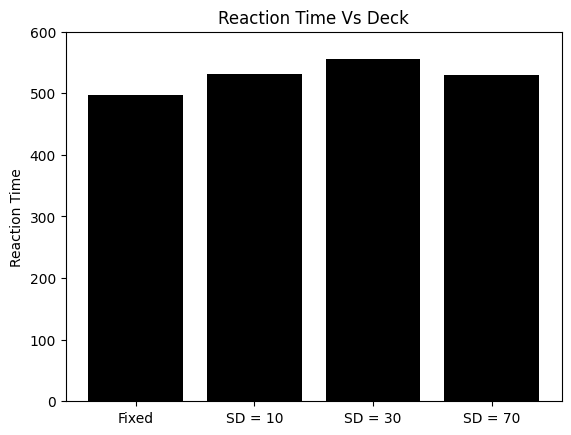

In [17]:
# bar plot of mean reaction time for different deck types
conditions = ["Fixed", "SD = 10", "SD = 30", "SD = 70"]
means = [reaction_time["fixed"].mean(), reaction_time["SD10"].mean(), reaction_time["SD30"].mean(), reaction_time["SD70"].mean()]

# Create bar plot
plt.bar(conditions, means, color="black")

# Set labels and title
plt.xlabel("")
plt.ylabel("Reaction Time")
plt.ylim(0, 600)
plt.title("Reaction Time Vs Deck")

# Save plot as image
plt.savefig(RESULTS_FOLDER+'Reaction_Time_Vs_Deck.png')

# Show plot
plt.show()

In [18]:
# Create a function to better format the numeric values
def abbreviateSTR(value, prefix):
    ret = []
    for item in value:
        if np.isnan(item) or pd.isna(item):
            ret.append('')
            continue
        item = round(item, 2)
        if item == 0:
            item = '<.01'
        item = str(item)
        item = item.lstrip('0')  # remove leading 0: 0.05 -> .05
        item = item.replace('-0', '-')  # remove leading -0: -0.05 -> -.05
        ret.append(prefix + item)
    return ret

## Linear regression

In [63]:
# Linear regression analysis and checking for multicollinearity using VIF
corr_data = pd.concat([preference["fixed"], questionnaire_data.iloc[:, [5, 6, 7, 8, 9, 10, 12, 13, 14, 15]]], axis=1)
corr_data.columns = ["fixed_deck", 'AQ_social', 'AQ_switch', 'AQ_detail', 'AQ_comm', 'AQ_imag', 'AQ_binary', 'SRS_consc', 'SRS_comm', 'SRS_motiv', 'SRS_rigid']

# Handle missing values by imputing with mean
corr_data.fillna(corr_data.mean(), inplace=True)

# Fit linear regression model
X = corr_data[['AQ_social', 'AQ_switch', 'AQ_detail', 'AQ_comm', 'AQ_imag', 'AQ_binary', 'SRS_consc', 'SRS_comm', 'SRS_motiv', 'SRS_rigid']]
X = sm.add_constant(X)  # Add constant term
y = corr_data['fixed_deck']
fitScores = sm.OLS(y, X).fit()

# Print summary statistics
print(fitScores.summary())

# Calculate VIF
vif_data = X.drop(columns='const')
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
print(vif)

                            OLS Regression Results                            
Dep. Variable:             fixed_deck   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.8218
Date:                Tue, 16 Apr 2024   Prob (F-statistic):              0.608
Time:                        15:08:39   Log-Likelihood:                -649.20
No. Observations:                 152   AIC:                             1320.
Df Residuals:                     141   BIC:                             1354.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4671     21.240      1.952      0.0

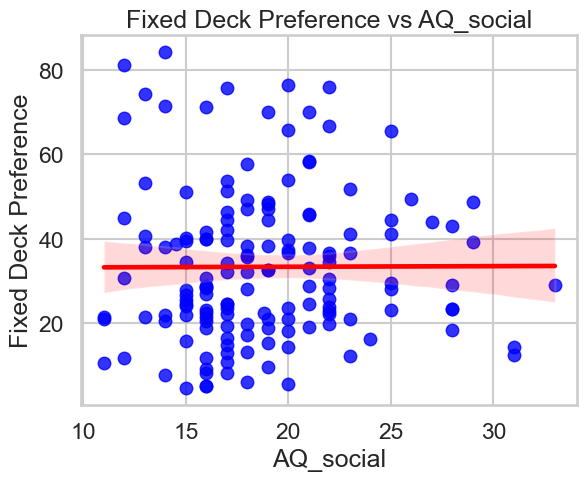

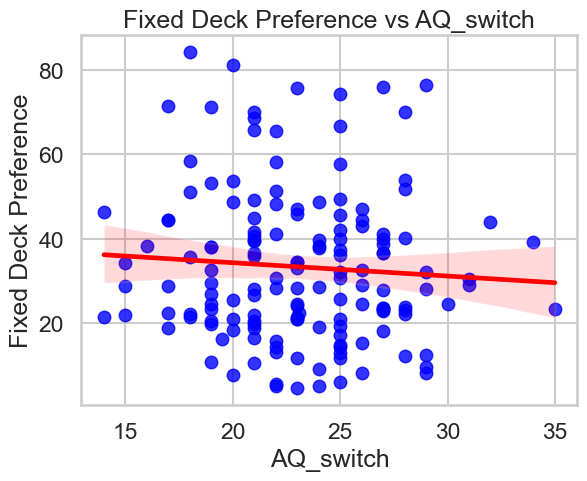

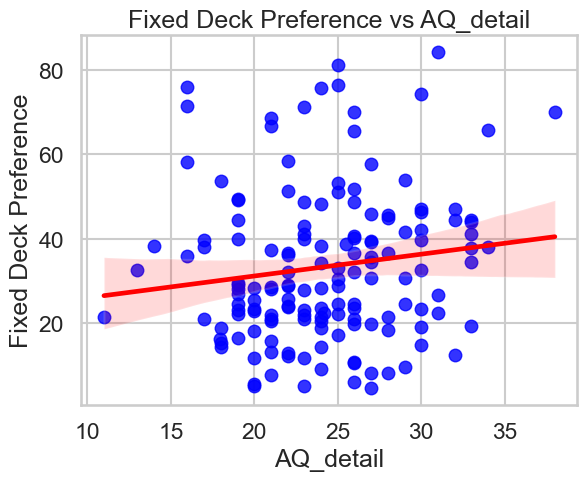

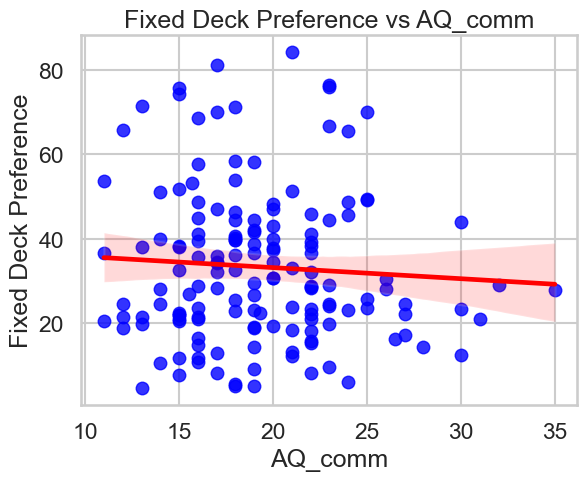

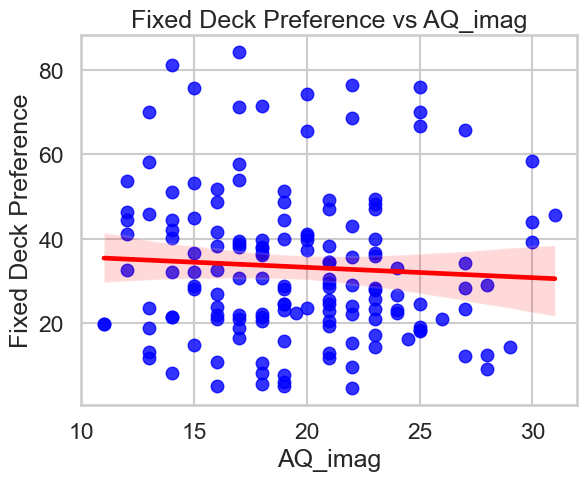

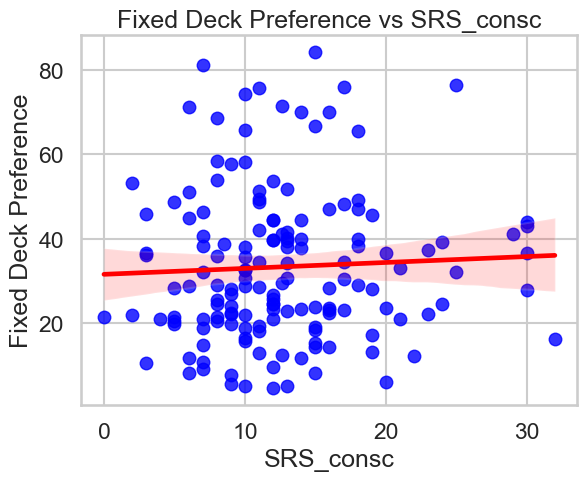

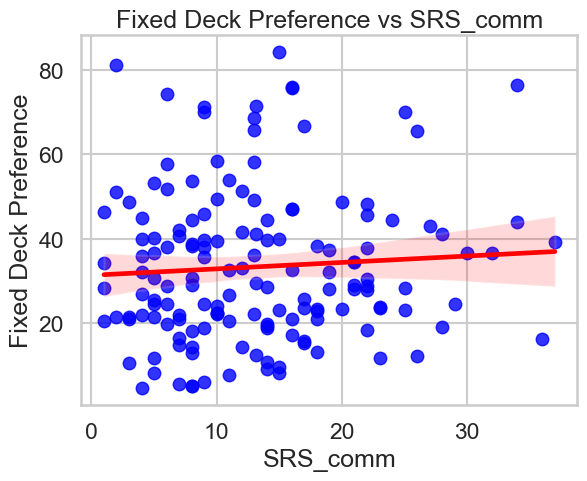

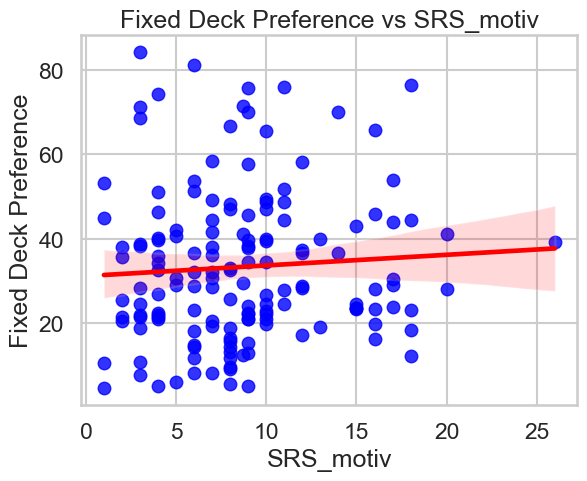

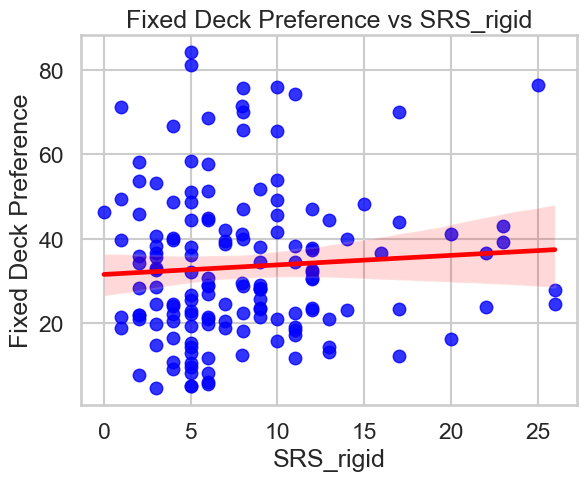

In [69]:
# Create plots of the regression
def generate_effect_plot(pred_var, filename):
    # Function to plot the regression effect
    # fig, ax = plt.subplots(figsize=(10, 7))
    sns.regplot(x=pred_var, y='fixed_deck', data=corr_data,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    plt.xlabel(pred_var)
    plt.ylabel('Fixed Deck Preference')
    plt.title(f'Fixed Deck Preference vs {pred_var}')
    plt.savefig(RESULTS_FOLDER+filename)
    plt.show()

# Generate effect plots and save images
generate_effect_plot('AQ_social', 'LM-FixedDeck_Vs_AQSocial.png')
generate_effect_plot('AQ_switch', 'LM-FixedDeck_Vs_AQSwitch.png')
generate_effect_plot('AQ_detail', 'LM-FixedDeck_Vs_AQDetail.png')
generate_effect_plot('AQ_comm', 'LM-FixedDeck_Vs_AQComm.png')
generate_effect_plot('AQ_imag', 'LM-FixedDeck_Vs_AQImag.png')
generate_effect_plot('SRS_consc', 'LM-FixedDeck_Vs_SRSConsc.png')
generate_effect_plot('SRS_comm', 'LM-FixedDeck_Vs_SRSComm.png')
generate_effect_plot('SRS_motiv', 'LM-FixedDeck_Vs_SRSMotiv.png')
generate_effect_plot('SRS_rigid', 'LM-FixedDeck_Vs_SRSRigid.png')

In [71]:
# Relation between factorscores, AQ_total, SRS_total and preference for fixed deck
corr_data = pd.concat([preference["fixed"], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)

# Rename the columns for better understanding
corr_data.columns = ["preference_fixed", 'AQ_total', 'SRS_total', 'factorscores']
# Handle missing values by imputing with mean
corr_data.fillna(corr_data.mean(), inplace=True)
X = corr_data[['AQ_total', 'SRS_total', 'factorscores']]
y = corr_data['preference_fixed']

# Add a constant term to the predictor variables matrix for the intercept
X = sm.add_constant(X)

# Fit the linear regression model
fitScores_orig = sm.OLS(y, X).fit()

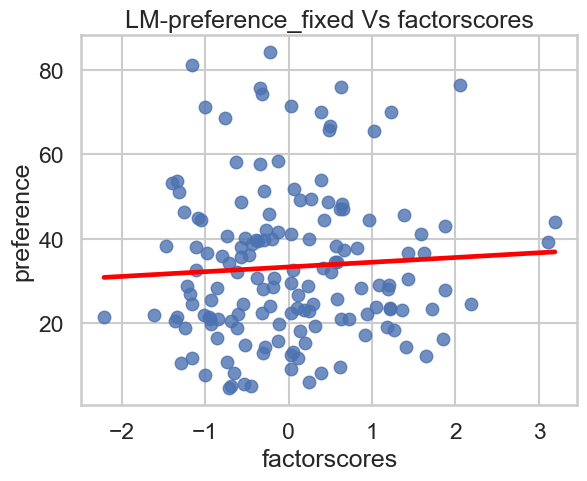

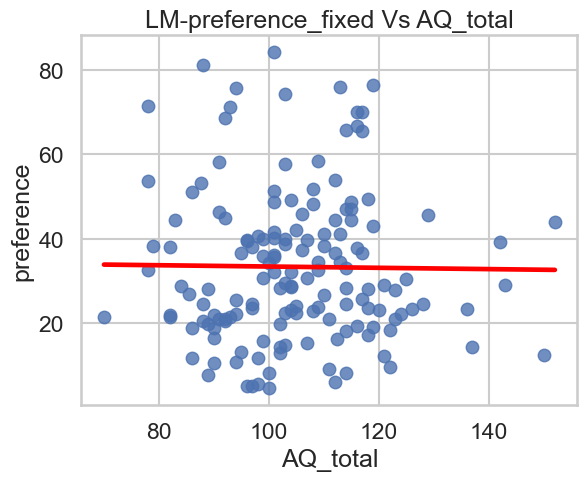

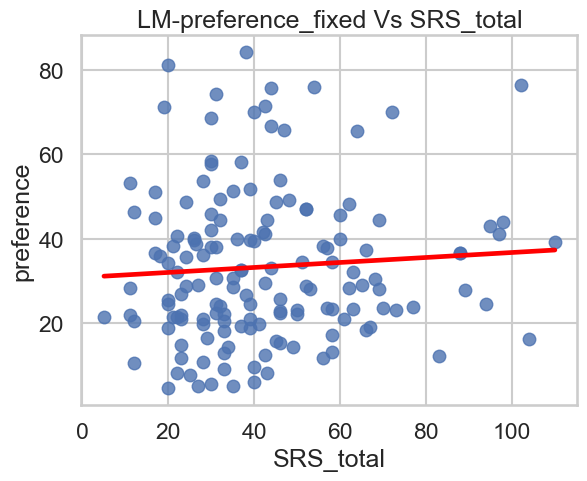

In [77]:
# Plot the residuals
def generate_effect_plot(pred_var, fit_model, filename):
    # Scatter plot of predictor variable vs residuals
    # plt.scatter(corr_data[pred_var], fit_model.resid, label='Data')
    sns.regplot(x=pred_var, y='preference_fixed', data=corr_data, ci=None, line_kws={'color': 'red'})

    plt.title(f'LM-preference_fixed Vs {pred_var}')
    plt.xlabel(pred_var)
    plt.ylabel('preference')
    plt.savefig(RESULTS_FOLDER+filename)
    plt.show()
    plt.close()

# Generate effect plots without trend lines and save images
generate_effect_plot('factorscores', fitScores_orig, 'LM-preference_fixed_Vs_factorscores.png')
generate_effect_plot('AQ_total', fitScores_orig, 'LM-preference_fixed_Vs_AQ_total.png')
generate_effect_plot('SRS_total', fitScores_orig, 'LM-preference_fixed_Vs_SRS_total.png')

In [26]:
# Linear regression on preference for fixed deck against AQ_total and SRS_total
X = sm.add_constant(corr_data[['AQ_total', 'SRS_total']])
y = corr_data['preference_fixed']
fitScores_orig = sm.OLS(y, X).fit()

# Print summary of regression results
print(fitScores_orig.summary())

# Calculate VIF for each predictor
vif_data = X.drop(columns='const')
vif_series = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index=vif_data.columns)
print('VIF:')
print(vif_series) 

                            OLS Regression Results                            
Dep. Variable:       preference_fixed   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8091
Date:                Tue, 16 Apr 2024   Prob (F-statistic):              0.447
Time:                        14:39:07   Log-Likelihood:                -652.69
No. Observations:                 152   AIC:                             1311.
Df Residuals:                     149   BIC:                             1320.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4358     11.868      3.491      0.0

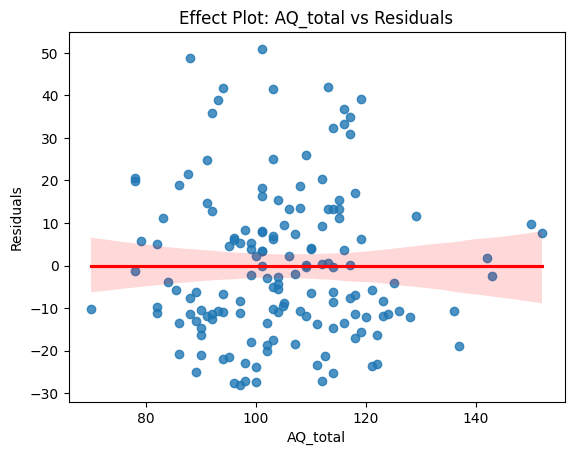

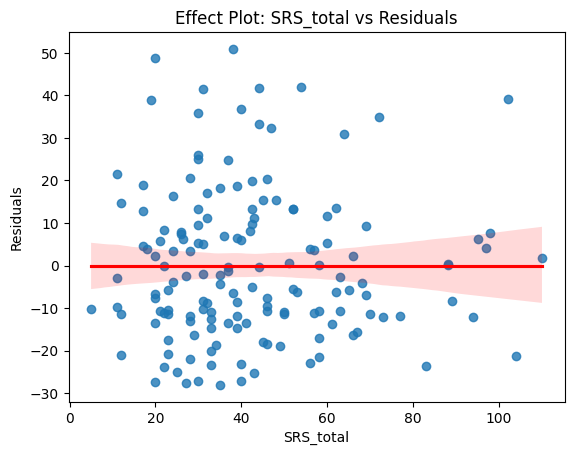

In [61]:
# Effect plot for AQ_total
# sns.scatterplot(x=corr_data['AQ_total'], y=fitScores_orig.resid)
sns.regplot(x=corr_data['AQ_total'], y=fitScores_orig.resid, line_kws={'color': 'red'})
plt.xlabel('AQ_total')
plt.ylabel('Residuals')
plt.title('Effect Plot: AQ_total vs Residuals')
plt.savefig(RESULTS_FOLDER+'LM-FixedDeck_Vs_AQ_Total.png')
plt.show()

# Effect plot for SRS_total
# sns.scatterplot(x=corr_data['SRS_total'], y=fitScores_orig.resid)
sns.regplot(x=corr_data['SRS_total'], y=fitScores_orig.resid, line_kws={'color': 'red'})
plt.xlabel('SRS_total')
plt.ylabel('Residuals')
plt.title('Effect Plot: SRS_total vs Residuals')
plt.savefig(RESULTS_FOLDER+'LM-FixedDeck_Vs_SRS_Total.png')
plt.show()

In [27]:
# Calculate AIC for fitScores_orig
aic_orig = fitScores_orig.aic

# Calculate AIC for fitScores (assuming you have fitScores available)
aic = fitScores.aic

print("AIC for fitScores_orig:", aic_orig) # Lesser aic suggests a potentially better model
print("AIC for fitScores:", aic)

AIC for fitScores_orig: 1311.373197308398
AIC for fitScores: 1320.404614196906


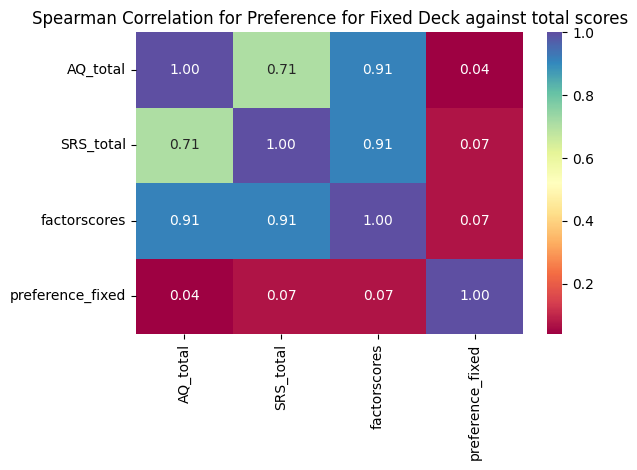

In [59]:
# Plot the spearmans correlation between preference for corr_data
cormatrix, p_values = spearmanr(corr_data)

# Convert correlation matrix to DataFrame
cordata = pd.DataFrame(cormatrix, index=corr_data.columns, columns=corr_data.columns)

# Melt the DataFrame to long format
cordata = cordata.unstack().reset_index(name='value').rename(columns={'level_0': 'X1', 'level_1': 'X2'})

# Abbreviate correlation values
cordata['labelr'] = cordata['value'].apply(lambda x: f'{x:.2f}')

# Create a pivot table
cordata_pivot = cordata.pivot_table(index='X1', columns='X2', values='value')

# Create a heatmap
sns.heatmap(cordata_pivot, annot=True, fmt=".2f", cmap='Spectral')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Spearman Correlation for Preference for Fixed Deck against total scores')
plt.tight_layout()

# Save the plot
plt.savefig(RESULTS_FOLDER+"Correlations_of_Deck_with_totals_Spearman.png")
plt.show()

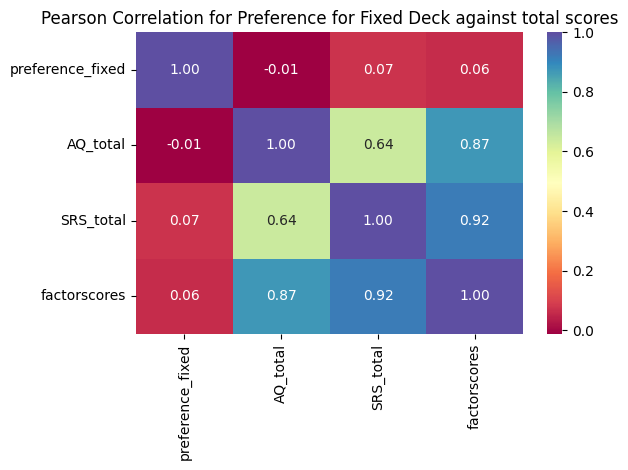

In [60]:
# Pearson correlation between preference for fixed deck and AQ_total
cormatrix = corr_data.corr(method='pearson')

# Melt the DataFrame to long format
cordata = cormatrix.unstack().reset_index(name='value').rename(columns={'level_0': 'X1', 'level_1': 'X2'})

# Abbreviate correlation values
cordata['labelr'] = cordata['value'].apply(lambda x: f'{x:.2f}')

# Create a heatmap
sns.heatmap(cormatrix, annot=True, fmt=".2f", cmap='Spectral')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Pearson Correlation for Preference for Fixed Deck against total scores')
plt.tight_layout()

# Save the plot
plt.savefig(RESULTS_FOLDER+"Correlations_of_Deck_with_totals_Pearson.png")
plt.show()

C:\Users\aabhi\AppData\Local\Temp\ipykernel_19180\2629049073.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  label_df_r = correlation_matrix.applymap(lambda x: abbreviateSTR([x], 'r=')[0])
C:\Users\aabhi\AppData\Local\Temp\ipykernel_19180\2629049073.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  label_df_p = correlation_matrix.applymap(lambda x: abbreviateSTR([x], 'P=')[0])


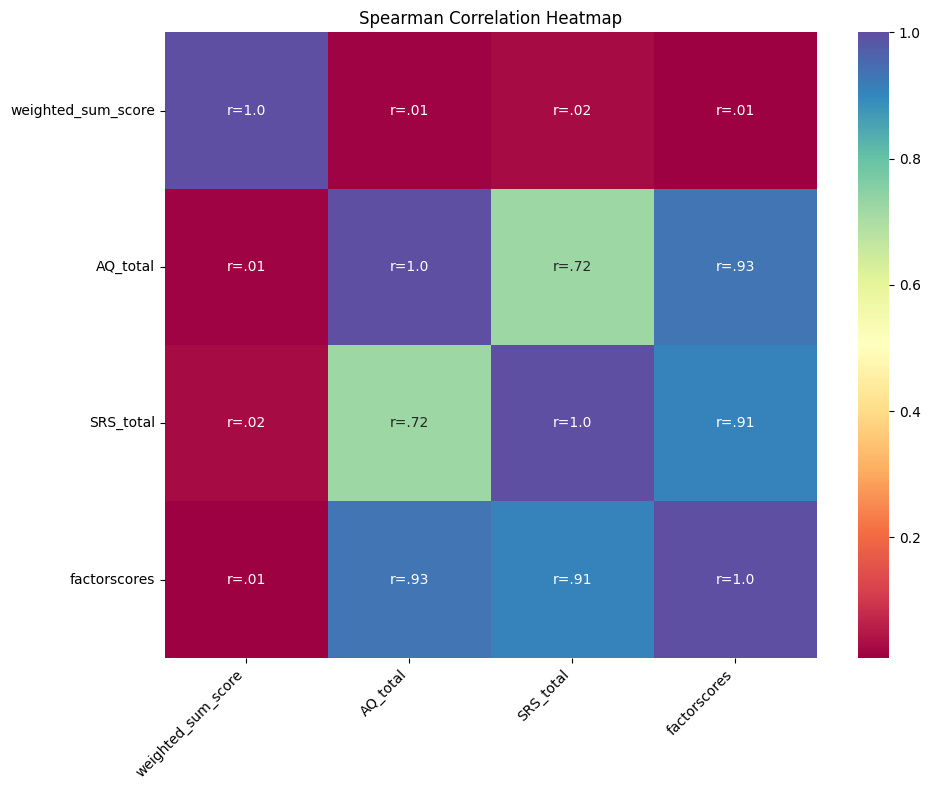

In [29]:
# Correlation between weighted sum 
weighted_sum_score = (preference['fixed'] * 1) + (preference['SD10'] * 2) + (preference['SD30'] * 3) + (preference['SD70'] * 4)

# Combine data into a DataFrame
corr_data = pd.concat([weighted_sum_score, questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ['weighted_sum_score', 'AQ_total', 'SRS_total', 'factorscores']

# Calculate Spearman correlation
correlation_matrix = corr_data.corr(method='spearman')

# Apply abbreviateSTR function to format correlation coefficient and p-value strings
label_df_r = correlation_matrix.applymap(lambda x: abbreviateSTR([x], 'r=')[0])
label_df_p = correlation_matrix.applymap(lambda x: abbreviateSTR([x], 'P=')[0])

# Plot heatmap with formatted labels
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=label_df_r.values, cmap='Spectral', fmt="", annot_kws={"size": 10})
plt.title('Spearman Correlation Heatmap')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(RESULTS_FOLDER+"Correlations_of_weightedsums_with_totals_S.png")
plt.show()

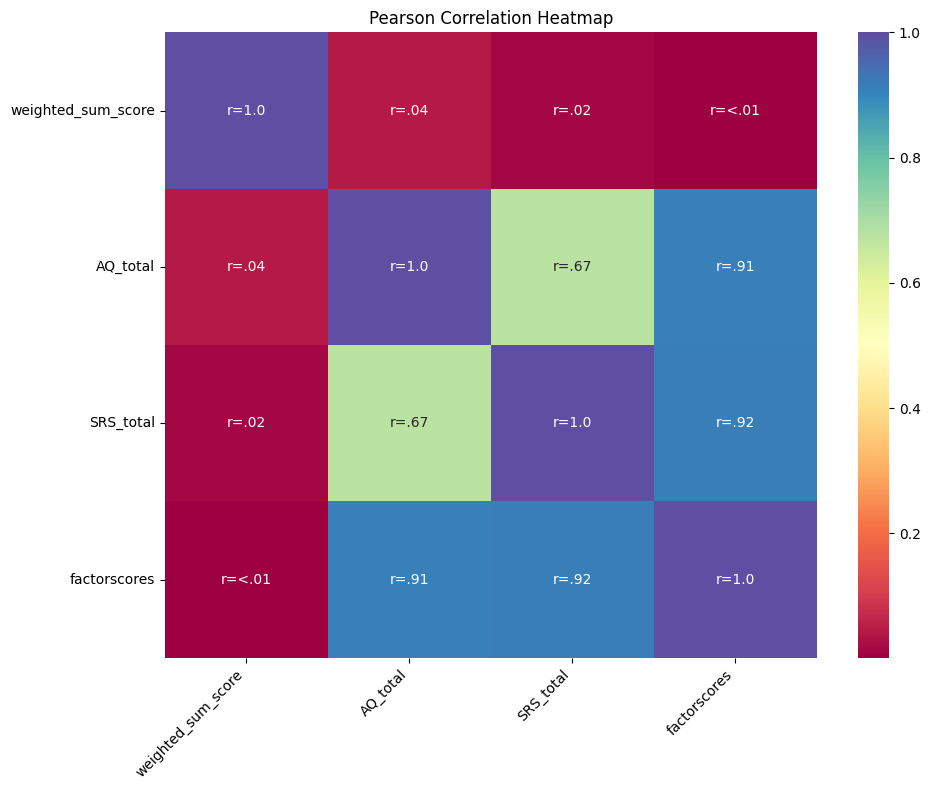

In [30]:
correlation_matrix = corr_data.corr(method='pearson')

# Melt the correlation matrix for visualization
cordata = correlation_matrix.reset_index().melt(id_vars='index')

# Apply abbreviateSTR function to format correlation coefficient and p-value strings
cordata['labelr'] = cordata['value'].apply(lambda x: abbreviateSTR([x], 'r=')[0])
cordata['labelP'] = cordata['value'].apply(lambda x: abbreviateSTR([x], 'P=')[0])
cordata['label'] = cordata['labelr']

# Plot heatmap with formatted labels
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=cordata['label'].values.reshape(correlation_matrix.shape), cmap='Spectral', fmt="", annot_kws={"size": 10})
plt.title('Pearson Correlation Heatmap')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(RESULTS_FOLDER+"Correlations_of_weightedsums_with_totals_P.png")
plt.show()

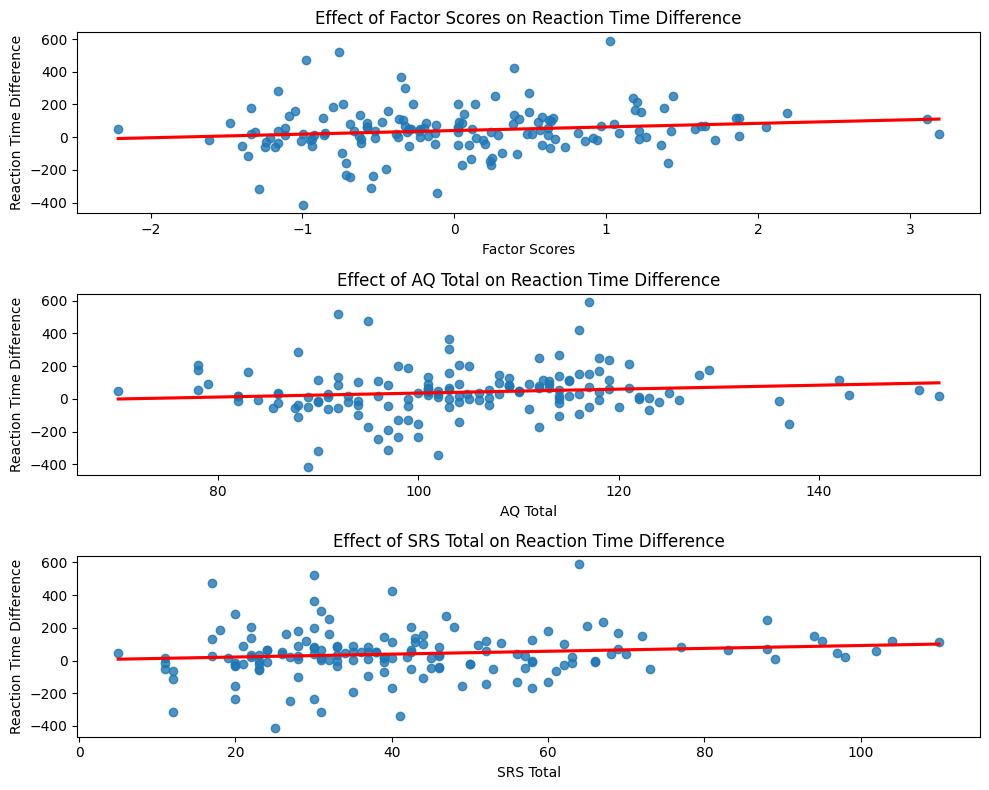

In [32]:
# Linear regression on reaction time as the response variable

reaction_time_diff = np.mean(reaction_time.iloc[:, 2:5], axis=1) - reaction_time['fixed']

# Combine with questionnaire data
corr_data = pd.concat([reaction_time_diff, questionnaire_data.iloc[:, [4, 11, 16]]], axis=1)
corr_data.columns = ['RT_diff', 'AQ_total', 'SRS_total', 'factorscores']
# Handle missing values by imputing with mean
corr_data.fillna(corr_data.mean(), inplace=True)

# Fit linear regression model
X = sm.add_constant(corr_data[['AQ_total', 'SRS_total', 'factorscores']])
y = corr_data['RT_diff']
fitScores_orig = sm.OLS(y, X).fit()

# Generate effect plots
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
# sns.scatterplot(data=corr_data, x='factorscores', y='RT_diff', color='blue', alpha=0.7)
sns.regplot(x='factorscores', y='RT_diff', data=corr_data, ci=None, line_kws={'color': 'red'})
plt.title('Effect of Factor Scores on Reaction Time Difference')
plt.xlabel('Factor Scores')
plt.ylabel('Reaction Time Difference')

plt.subplot(3, 1, 2)
# sns.scatterplot(data=corr_data, x='AQ_total', y='RT_diff', color='green', alpha=0.7)
sns.regplot(x='AQ_total', y='RT_diff', data=corr_data, ci=None, line_kws={'color': 'red'})
plt.title('Effect of AQ Total on Reaction Time Difference')
plt.xlabel('AQ Total')
plt.ylabel('Reaction Time Difference')

plt.subplot(3, 1, 3)
# sns.scatterplot(data=corr_data, x='SRS_total', y='RT_diff', color='red', alpha=0.7)
sns.regplot(x='SRS_total', y='RT_diff', data=corr_data, ci=None, line_kws={'color': 'red'})
plt.title('Effect of SRS Total on Reaction Time Difference')
plt.xlabel('SRS Total')
plt.ylabel('Reaction Time Difference')

plt.tight_layout()
plt.savefig(RESULTS_FOLDER+'LM_Totals_vs_RT.png')
plt.show()

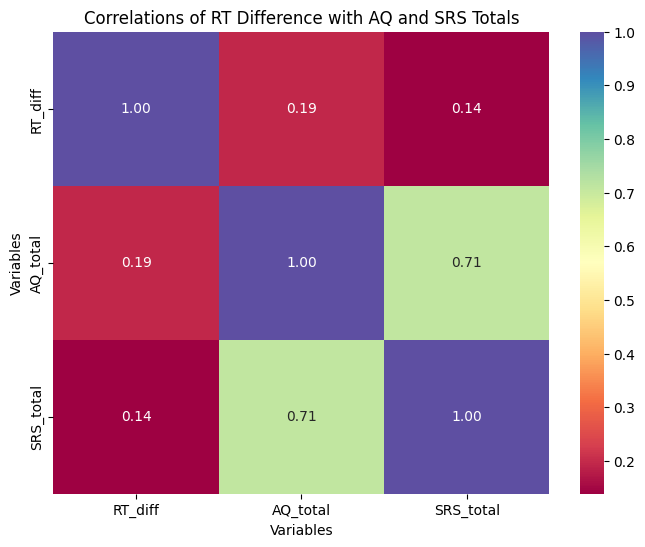

In [33]:
X = corr_data[['AQ_total', 'SRS_total']]
y = corr_data['RT_diff']
fitScores_orig = sm.OLS(y, sm.add_constant(X)).fit()

# Calculate Spearman correlation coefficients
spearman_corr, spearman_pval = spearmanr(corr_data[['RT_diff', 'AQ_total', 'SRS_total']], nan_policy='omit')

# Create DataFrame for correlation coefficients
cordata = pd.DataFrame(spearman_corr, columns=['RT_diff', 'AQ_total', 'SRS_total'])
cordata.index = ['RT_diff', 'AQ_total', 'SRS_total']
cordata.columns = ['RT_diff', 'AQ_total', 'SRS_total']

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cordata, annot=True, fmt=".2f", cmap='Spectral')
plt.title('Correlations of RT Difference with AQ and SRS Totals')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.savefig(RESULTS_FOLDER+'Correlations_of_RTDiff_with_totals_Spearman.png')
plt.show()

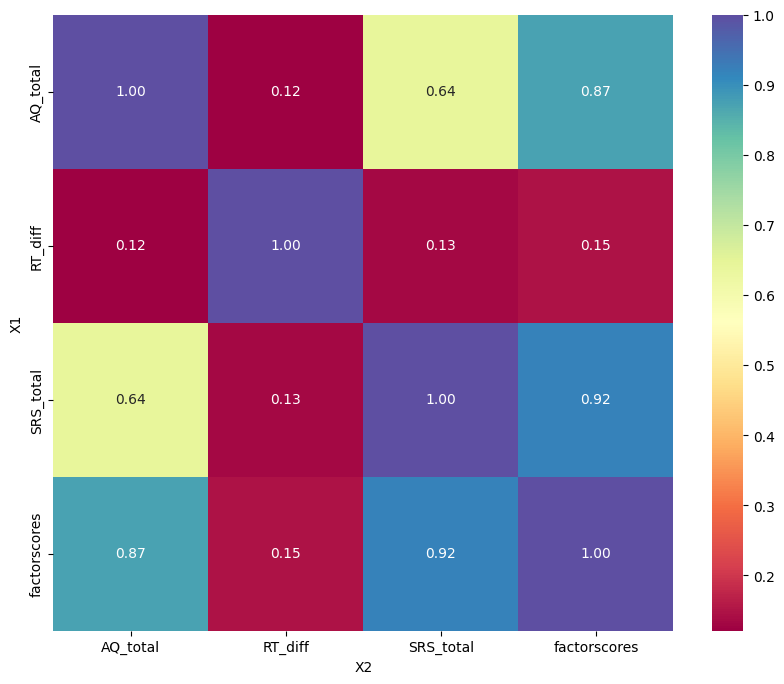

In [34]:
cormatrix = corr_data.corr(method='pearson')

# Reshape the correlation matrix into long format
cordata = cormatrix.unstack().reset_index()
cordata.columns = ['X1', 'X2', 'value']

# Apply abbreviateSTR function to format correlation coefficient strings
cordata['labelr'] = cordata['value'].apply(lambda x: abbreviateSTR([x], 'r=')[0])
cordata['labelP'] = cordata['value'].apply(lambda x: abbreviateSTR([x], 'P=')[0])
cordata['label'] = cordata['labelr'] + '\n' + cordata['labelP']

# Set up plot aesthetics
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(cordata.pivot(index='X1', columns='X2', values='value'), annot=True, fmt=".2f", cmap='Spectral')

# Save the plot
plt.savefig(RESULTS_FOLDER+"Correlations_of_RTDiff_with_totals_Pearson.png")

# Show the plot
plt.show()

## Linear Regression on RT difference

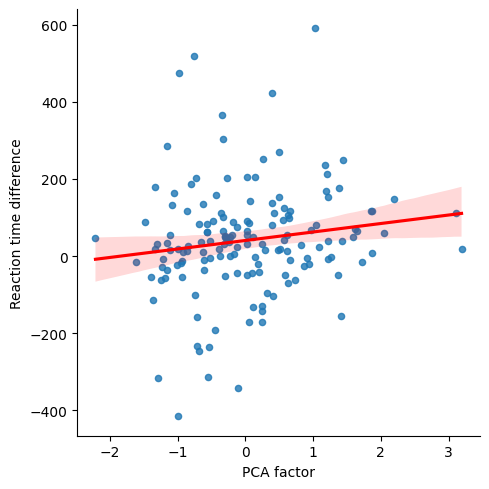

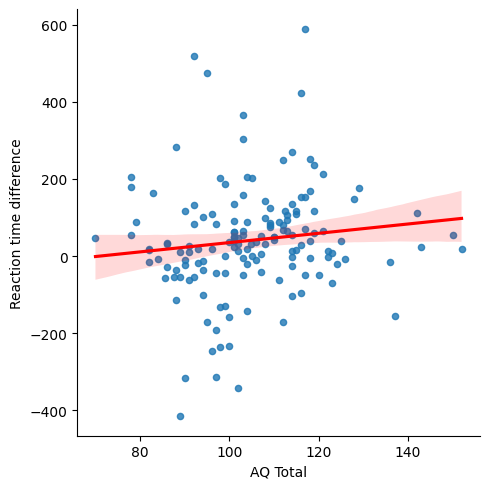

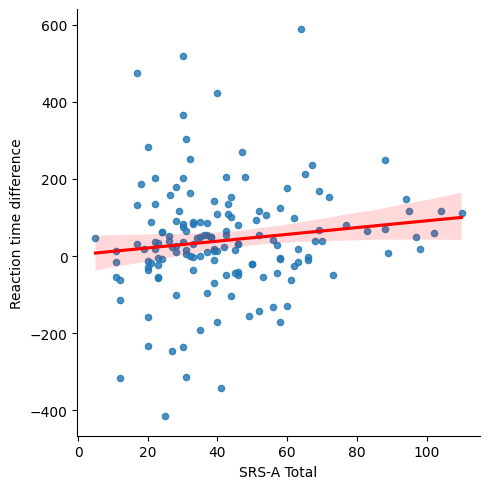

In [36]:
# Plot RT_diff vs. factorscores
p1 = sns.lmplot(x='factorscores', y='RT_diff', data=corr_data, scatter_kws={'s': 20},line_kws={'color': 'red'})
p1.set_axis_labels("PCA factor", "Reaction time difference")

# Plot RT_diff vs. AQ_total
p2 = sns.lmplot(x='AQ_total', y='RT_diff', data=corr_data, scatter_kws={'s': 20},line_kws={'color': 'red'})
p2.set_axis_labels("AQ Total", "Reaction time difference")

# Plot RT_diff vs. SRS_total
p3 = sns.lmplot(x='SRS_total', y='RT_diff', data=corr_data, scatter_kws={'s': 20},line_kws={'color': 'red'})
p3.set_axis_labels("SRS-A Total", "Reaction time difference")

# Save the combined plot
plt.savefig(RESULTS_FOLDER+'RT_vs_components.png')

# Show the plot
plt.show()

In [37]:
selected_columns1 = questionnaire_data.columns[4:10]  # Columns from 5th to 10th (inclusive)
selected_columns2 = questionnaire_data.columns[11:18]  # Columns from 12th to 17th (inclusive)
selected_columns = pd.Index(selected_columns1).union(selected_columns2)

# Combine the data for correlation matrix creation
corr_data = pd.concat([reaction_time_diff, questionnaire_data[selected_columns]], axis=1)

corr_data.columns = ["RT_diff", "AQ_total", "AQ_social", "AQ_switch", "AQ_detail", "AQ_comm", "AQ_imag", "SRS_total", "SRS_consc", "SRS_comm", "SRS_motiv", "SRS_rigid", "factorscores"]
corr_data.fillna(corr_data.mean(), inplace=True)

# Fit linear regression model
X = corr_data[['AQ_social', 'AQ_switch', 'AQ_detail', 'AQ_comm', 'AQ_imag', 'SRS_consc', 'SRS_comm', 'SRS_motiv', 'SRS_rigid']]
X = sm.add_constant(X)  # Add constant term
y = corr_data['RT_diff']
fitScores = sm.OLS(y, X).fit()

# Print model summary
print(fitScores.summary())

# Calculate VIF
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

# Calculate AIC
print(f"AIC for fitScores: {fitScores.aic}")
print(f"AIC for fitScores_orig: {fitScores_orig.aic}")

                            OLS Regression Results                            
Dep. Variable:                RT_diff   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.036
Date:                Tue, 16 Apr 2024   Prob (F-statistic):              0.414
Time:                        14:42:25   Log-Likelihood:                -965.18
No. Observations:                 152   AIC:                             1950.
Df Residuals:                     142   BIC:                             1981.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.8811     99.905     -1.050      0.2

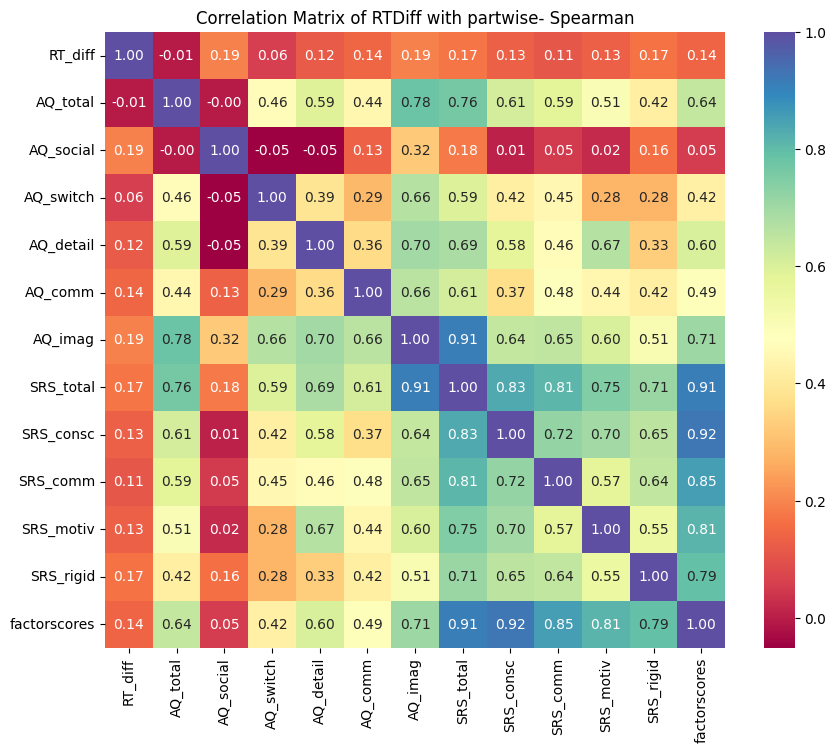

In [40]:
cormatrix = corr_data.corr(method='spearman')
cordata = cormatrix.unstack().reset_index(name='value').rename(columns={'level_0': 'X1', 'level_1': 'X2'})

# Abbreviate correlation values and p-values
cordata['labelr'] = abbreviateSTR(cordata['value'], 'r')
cordata['label'] = cordata['labelr']

# Create heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cormatrix, annot=True, fmt=".2f", cmap='Spectral', annot_kws={"size": 10})

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.title("Correlation Matrix of RTDiff with partwise- Spearman")

# Save the plot
plt.savefig(RESULTS_FOLDER+"Correlations_of_RTDiff_with_partwise_Spearman.png")
plt.show()

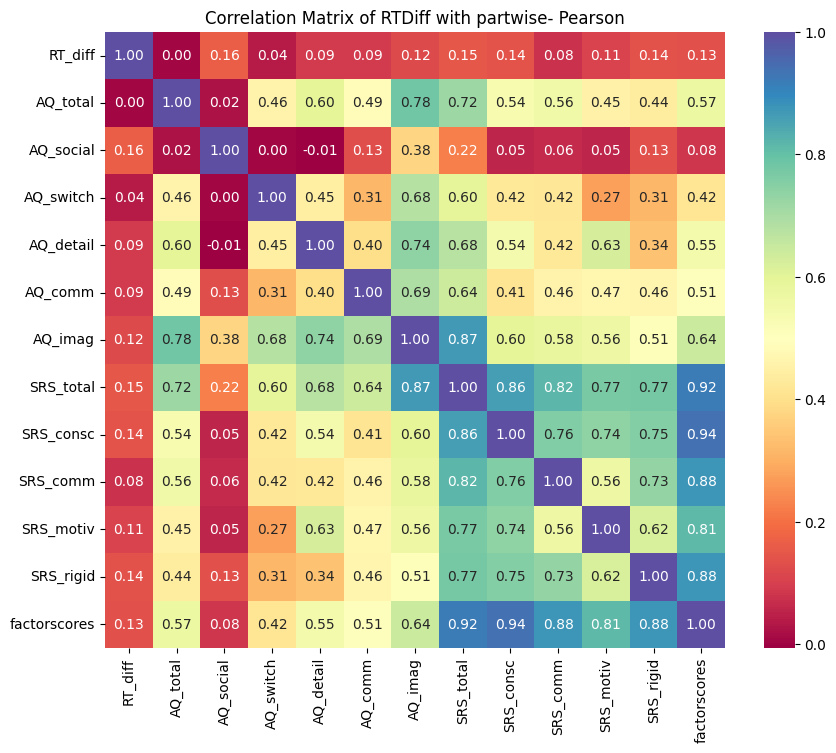

In [41]:
cormatrix = corr_data.corr(method='pearson')
cordata = cormatrix.unstack().reset_index(name='value').rename(columns={'level_0': 'X1', 'level_1': 'X2'})

# Abbreviate correlation values and p-values
cordata['labelr'] = abbreviateSTR(cordata['value'], 'r')
cordata['label'] = cordata['labelr']

# Create heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cormatrix, annot=True, fmt=".2f", cmap='Spectral', annot_kws={"size": 10})

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.title("Correlation Matrix of RTDiff with partwise- Pearson")

# Save the plot
plt.savefig(RESULTS_FOLDER+"Correlations_of_RTDiff_with_partwise_Pearson.png")
plt.show()


# New hypotheses: Checking if handedness has a role in the deck chosen

In [42]:
gambling_task_data.head()

,ppnr,order,trialnr,amount_won,W_value_win,X_value_win,Y_value_win,Z_value_win,r,real_r,rt,money
3,1,19,4,138,250,268,210,138,1,3.0,2726.879883,756
4,1,19,5,233,250,259,233,182,3,2.0,2387.823242,894
5,1,19,6,250,250,260,264,254,2,0.0,1518.036011,1127
6,1,19,7,250,250,251,250,223,3,2.0,1090.898071,1377
7,1,19,8,234,250,234,240,292,4,1.0,1209.557861,1627


In [43]:
# get preference for most right deck chosen (r=4) for right handed participants (questionnaire_data['handedness']='R')
right_handed = questionnaire_data[questionnaire_data['handedness'] == 'R']
left_handed = questionnaire_data[questionnaire_data['handedness'] == 'L']
# questionnaire_data.shape
right_handed.shape, left_handed.shape

((127, 17), (25, 17))

In [44]:
def calculate_deck_preference(hand_data, task_data, deck_choice):
    # Merge hand data with gambling task data
    merged_data = hand_data.merge(task_data, left_on='subj', right_on='ppnr')
    
    # Filter data for specified deck choice
    deck_pref_data = merged_data[merged_data['r'] == deck_choice]
    
    # # Calculate count of deck preference
    # deck_pref_count = deck_pref_data.shape[0]
    
    return deck_pref_data

In [45]:
merged_data_right = right_handed.merge(gambling_task_data, left_on='subj', right_on='ppnr')

merged_data_right.head()

,subj,age,gender,handedness,AQ_total,AQ_social,AQ_switch,AQ_detail,AQ_comm,AQ_imag,...,trialnr,amount_won,W_value_win,X_value_win,Y_value_win,Z_value_win,r,real_r,rt,money
0,1,20,F,R,142.0,29.0,34.0,27.0,22.0,30.0,...,4,138,250,268,210,138,1,3.0,2726.879883,756
1,1,20,F,R,142.0,29.0,34.0,27.0,22.0,30.0,...,5,233,250,259,233,182,3,2.0,2387.823242,894
2,1,20,F,R,142.0,29.0,34.0,27.0,22.0,30.0,...,6,250,250,260,264,254,2,0.0,1518.036011,1127
3,1,20,F,R,142.0,29.0,34.0,27.0,22.0,30.0,...,7,250,250,251,250,223,3,2.0,1090.898071,1377
4,1,20,F,R,142.0,29.0,34.0,27.0,22.0,30.0,...,8,234,250,234,240,292,4,1.0,1209.557861,1627


In [46]:
merged_data_left = left_handed.merge(gambling_task_data, left_on='subj', right_on='ppnr')
merged_data_left.head()

,subj,age,gender,handedness,AQ_total,AQ_social,AQ_switch,AQ_detail,AQ_comm,AQ_imag,...,trialnr,amount_won,W_value_win,X_value_win,Y_value_win,Z_value_win,r,real_r,rt,money
0,12,19,M,L,119.0,20.0,29.0,25.0,23.0,22.0,...,1,89,250,240,239,89,2,3.0,1031.769653,0
1,12,19,M,L,119.0,20.0,29.0,25.0,23.0,22.0,...,2,262,250,225,262,208,3,2.0,976.571167,89
2,12,19,M,L,119.0,20.0,29.0,25.0,23.0,22.0,...,3,250,250,245,247,288,1,0.0,947.527771,351
3,12,19,M,L,119.0,20.0,29.0,25.0,23.0,22.0,...,4,235,250,235,221,119,4,1.0,455.657196,601
4,12,19,M,L,119.0,20.0,29.0,25.0,23.0,22.0,...,5,251,250,252,251,454,3,2.0,311.779816,836


In [47]:
from scipy import stats

# Perform Shapiro-Wilk test for normality
shapiro_right = stats.shapiro(merged_data_right['r'])
shapiro_left = stats.shapiro(merged_data_left['r'])

# Perform Levene's test for homogeneity of variances
levene_statistic, levene_p_value = stats.levene(merged_data_right['r'], merged_data_left['r'])

# Print the results
print("Shapiro-Wilk Test for Normality:")
print("Right-handed individuals preferring right-most decks:", shapiro_right)
print("Right-handed individuals preferring left-most decks:", shapiro_left)

print("\nLevene's Test for Homogeneity of Variances:")
print("Levene's Test Statistic:", levene_statistic)
print("P-Value:", levene_p_value)

# Check the assumptions
if all(p > 0.05 for p in [shapiro_right[1], shapiro_left[1]]):
    print("All groups are normally distributed.")
else:
    print("At least one group is not normally distributed.")

if levene_p_value > 0.05:
    print("Homogeneity of variances is satisfied.")
else:
    print("Homogeneity of variances is not satisfied.")


Shapiro-Wilk Test for Normality:
Right-handed individuals preferring right-most decks: ShapiroResult(statistic=0.8542151445835038, pvalue=2.8557062348210834e-90)
Right-handed individuals preferring left-most decks: ShapiroResult(statistic=0.8594386784774688, pvalue=1.0496976949968202e-54)

Levene's Test for Homogeneity of Variances:
Levene's Test Statistic: 12.64115063403338
P-Value: 0.00037793334602018706
At least one group is not normally distributed.
Homogeneity of variances is not satisfied.


C:\Users\aabhi\AppData\Local\Temp\ipykernel_19180\2173347544.py:4: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 24836.
  shapiro_right = stats.shapiro(merged_data_right['r'])


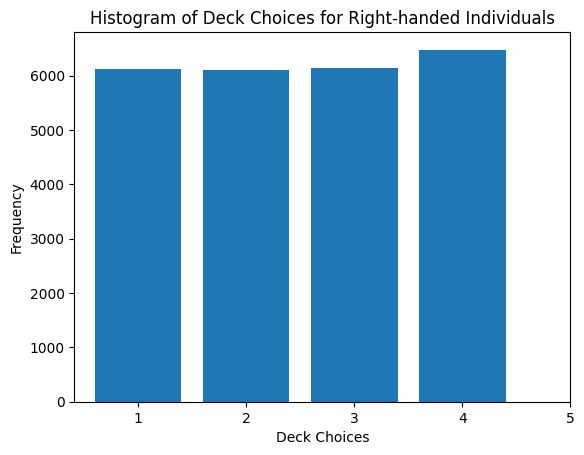

In [48]:
deck_choices = merged_data_right['r']

# Create a histogram of deck choices
plt.hist(deck_choices, bins=range(1, 6), align='left', rwidth=0.8)

# Set labels and title
plt.xlabel('Deck Choices')
plt.ylabel('Frequency')
plt.title('Histogram of Deck Choices for Right-handed Individuals')

# Set x-axis ticks
plt.xticks(range(1, 6))

# Show the plot
plt.show()

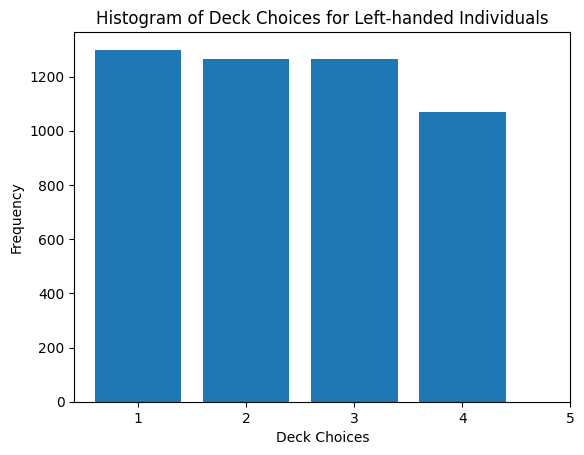

In [49]:
deck_choices = merged_data_left['r']

# Create a histogram of deck choices
plt.hist(deck_choices, bins=range(1, 6), align='left', rwidth=0.8)

# Set labels and title
plt.xlabel('Deck Choices')
plt.ylabel('Frequency')
plt.title('Histogram of Deck Choices for Left-handed Individuals')

# Set x-axis ticks
plt.xticks(range(1, 6))

# Show the plot
plt.show()

In [50]:
# Calculate preference for right-most and left-most decks for right-handed individuals
right_pref_right = calculate_deck_preference(right_handed, gambling_task_data, 4)
right_pref_left = calculate_deck_preference(right_handed, gambling_task_data, 1)

# Calculate preference for right-most and left-most decks for left-handed individuals
left_pref_right = calculate_deck_preference(left_handed, gambling_task_data, 4)
left_pref_left = calculate_deck_preference(left_handed, gambling_task_data, 1)

In [51]:
right_pref_right.shape,right_pref_left.shape

((6475, 29), (6124, 29))

In [52]:
left_pref_left,left_pref_right

(      subj  age gender handedness  AQ_total  AQ_social  AQ_switch  AQ_detail  \
 2       12   19      M          L     119.0       20.0       29.0       25.0   
 6       12   19      M          L     119.0       20.0       29.0       25.0   
 12      12   19      M          L     119.0       20.0       29.0       25.0   
 16      12   19      M          L     119.0       20.0       29.0       25.0   
 19      12   19      M          L     119.0       20.0       29.0       25.0   
 ...    ...  ...    ...        ...       ...        ...        ...        ...   
 4890   151   20      M          L     101.0       18.0       25.0       22.0   
 4891   151   20      M          L     101.0       18.0       25.0       22.0   
 4892   151   20      M          L     101.0       18.0       25.0       22.0   
 4893   151   20      M          L     101.0       18.0       25.0       22.0   
 4894   151   20      M          L     101.0       18.0       25.0       22.0   
 
       AQ_comm  AQ_imag  .

In [53]:
u_statistic, mann_whitney_p_value = stats.mannwhitneyu(merged_data_right['r'], merged_data_left['r'])

# Print the results
print("Mann-Whitney U test:")
print("U-Statistic:", u_statistic)
print("P-Value:", mann_whitney_p_value)

# Check the significance
if mann_whitney_p_value < 0.05:
    print("Reject null hypothesis. Handedness likely affects deck preference.")
else:
    print("Fail to reject null hypothesis. Handedness might not affect deck preference.")

Mann-Whitney U test:
U-Statistic: 63581834.5
P-Value: 1.4322307563674936e-07
Reject null hypothesis. Handedness likely affects deck preference.


Hence, the hypothesis that handedness likely has an effect on the chosen deck is true